## Project Kickstarter 
by Vivika Wilde wilde.vivika@gmail.com
   Sebastian Fuhrer fuhrer_sebastian@web.de

## Objective 

In recent years, the range of funding options for projects created by individuals and small companies has expanded considerably. In addition to savings, bank loans, friends & family funding and other traditional options, crowdfunding has become a popular and readily available alternative. 

Kickstarter, founded in 2009, is one particularly well-known and popular crowdfunding platform. It has an all-or-nothing funding model, whereby a project is only funded if it meets its goal amount; otherwise no money is given by backers to a project.
A huge variety of factors contribute to the success or failure of a project — in general, and also on Kickstarter. Some of these are able to be quantified or categorized, which allows for the construction of a model to attempt to predict whether a project will succeed or not. The aim of this project is to construct such a model and also to analyse Kickstarter project data more generally, in order to help potential project creators assess whether or not Kickstarter is a good funding option for them, and what their chances of success are.


## Set up

In [1]:
%reset -fs

In [2]:
import glob, os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import json
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



from xgboost import XGBClassifier

%matplotlib inline
plt.style.use("ggplot")

# Set random seed 
RSEED = 42

In [3]:
data = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "data/*.csv"))))
data = data.reset_index(drop=True)

In [4]:
df = data.copy()

## Variable names and description

* **backers_count** - Number of supporters/investors
* **blurb** - A short description of the product written for promotional purposes
* **category** - Projects have been classified into 16 categories. These categories broadly define the genre a project belongs to. **Subcategory** - Categories are further sub-divided in subcategories to give more details on the project. For instance, the category “Technology” has further been split into subcategories like Gadgets, Web, Apps, Software etc. There are 144 total subcategories.
* **converted_pledged_amount** - Total pledged amount in USD.
* **country** - Country of origin of the project
* **created_at** - Date when Project was created (timestamp)
* **creator** - Information on the Creator including ID, name, etc.
* **currency** - Currency used to support the project (3-letter code)
* **currency_symbol** - Symbol of the currency
* **currency_trailing_code** - Defines whether the currency codes are always shown after the amount, independent of the locale.
* **current_currency**
* **deadline** - The date before which the goal amount has to be gathered.
* **disable_communication**
* **friends** - No values given (208922 NaN and 300 empty lists)
* **fx_rate**
* **goal** - Funding amount the project initially asked for in the original currency
* **id** - Project ID
* **is_backing** - No values given (208922 NaN and 300 empty lists)
* **is_starrable** - Whether the project can be marked as favourite or not
* **is_starred** - Whether the project was marked as favourite or not
* **launched_at** - Launch date of the project (timestamp)
* **location** - Project location
* **name** - Project name
* **permissions** - No values given (208922 NaN and 300 empty lists)
* **photo** - Project photo
* **pledged** - Pledge amount in original currency
* **profile**
* **slug**
* **source_url** - URL to the category the project belongs to
* **spotlight** - Spotlight allows creators to make a home for their project on Kickstarter after they've been successfully funded. Each creator can take control of their page and build a customized, central hub for news, updates, links to finished work, and anything else they want the world to know about their project
* **staff_pick** - Staff picks was a feature that highlighted promising projects on the site to give them a boost by helping them get exposure through the email newsletter and highlighted spots around the site. The old 'Kickstarter Staff Pick' badge.
* **state** - Was the project successful at the end of the day? state is a categorical variable divided into the levels successful, failed, live, cancelled, undefined and suspended. 
* **state_changed_at** - Date the state was changed last (timestamp)
* **static_usd_rate** - Conversion rate used by Kickstarter to calculate usd_pledged
* **urls** - URL to the project's side 
* **usd_pledged** - Pledged amount in USD (conversion made by Kickstarter)
* **usd_type** - whether current currency USD are domestic or foreign

## Data types and missings

In [5]:
df.head(2)

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,...,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,315,Babalus Shoes,"{""id"":266,""name"":""Footwear"",""slug"":""fashion/fo...",28645,US,1541459205,"{""id"":2094277840,""name"":""Lucy Conroy"",""slug"":""...",USD,$,True,...,babalus-childrens-shoes,https://www.kickstarter.com/discover/categorie...,False,False,live,1548223375,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",28645.0,international
1,47,A colorful Dia de los Muertos themed oracle de...,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",1950,US,1501684093,"{""id"":723886115,""name"":""Lisa Vollrath"",""slug"":...",USD,$,True,...,the-ofrenda-oracle-deck,https://www.kickstarter.com/discover/categorie...,True,False,successful,1504976459,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",1950.0,domestic


In [6]:
df.tail(2)

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,...,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
209220,76,Seattle Transmedia & Independent Film Festival...,"{""id"":295,""name"":""Festivals"",""slug"":""film & vi...",5692,US,1425256957,"{""id"":307076473,""name"":""Timothy Vernor"",""is_re...",USD,$,True,...,transmedia-gallery-space-stiff-2015,https://www.kickstarter.com/discover/categorie...,True,False,successful,1429536379,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",5692.0,domestic
209221,44,The @1000TimesYes 2009 Tweet Box is a handmade...,"{""id"":13,""name"":""Journalism"",""slug"":""journalis...",1293,US,1263225900,"{""id"":1718677513,""name"":""Article"",""slug"":""arti...",USD,$,True,...,the-1000timesyes-2009-tweet-box,https://www.kickstarter.com/discover/categorie...,True,True,successful,1266814815,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",1293.0,domestic


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209222 entries, 0 to 209221
Data columns (total 37 columns):
backers_count               209222 non-null int64
blurb                       209214 non-null object
category                    209222 non-null object
converted_pledged_amount    209222 non-null int64
country                     209222 non-null object
created_at                  209222 non-null int64
creator                     209222 non-null object
currency                    209222 non-null object
currency_symbol             209222 non-null object
currency_trailing_code      209222 non-null bool
current_currency            209222 non-null object
deadline                    209222 non-null int64
disable_communication       209222 non-null bool
friends                     300 non-null object
fx_rate                     209222 non-null float64
goal                        209222 non-null float64
id                          209222 non-null int64
is_backing                  300 

### Missing Data

In [8]:
missing = pd.DataFrame(df.isnull().sum(), columns=['Number'])
missing['Percentage'] = round(missing.Number / df.shape[0] * 100, 1)
missing[missing.Number != 0]

,Number,Percentage
blurb,8,0.0
friends,208922,99.9
is_backing,208922,99.9
is_starred,208922,99.9
location,226,0.1
permissions,208922,99.9
usd_type,480,0.2


For the features 'friends', 'is_backing', 'is_starred' and 'permissions' only .1 percent of the data is given.
Therefore these features are not useable  and will be removed from the set. 


In [9]:
df.drop(['friends', 'permissions', 'is_backing', 'is_starred'], axis=1, inplace=True);

### State

In [10]:
df.state.value_counts()

successful    117465
failed         75199
canceled        8624
live            7311
suspended        623
Name: state, dtype: int64

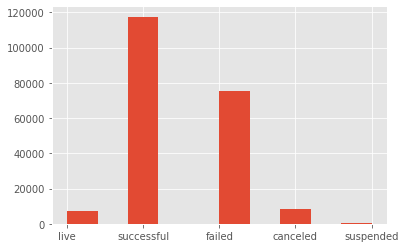

In [11]:
df.state.hist()

In [12]:
df.describe().round(2)

,backers_count,converted_pledged_amount,created_at,deadline,fx_rate,goal,id,launched_at,pledged,state_changed_at,static_usd_rate,usd_pledged
count,209222.00,209222.00,2.092220e+05,2.092220e+05,209222.00,2.092220e+05,2.092220e+05,2.092220e+05,209222.00,2.092220e+05,209222.00,209222.00
mean,145.42,12892.90,1.456089e+09,1.463033e+09,0.99,4.917604e+04,1.073222e+09,1.460206e+09,18814.03,1.462838e+09,1.01,12892.13
std,885.97,88894.14,6.339711e+07,6.305618e+07,0.21,1.179427e+06,6.198051e+08,6.309029e+07,322959.62,6.290421e+07,0.23,88901.24
min,0.00,0.00,1.240366e+09,1.241334e+09,0.01,1.000000e-02,8.624000e+03,1.240603e+09,0.00,1.241334e+09,0.01,0.00
25%,4.00,106.00,1.413317e+09,1.420607e+09,1.00,1.500000e+03,5.351054e+08,1.417639e+09,110.00,1.420485e+09,1.00,106.00
50%,27.00,1537.00,1.457895e+09,1.464754e+09,1.00,5.000000e+03,1.074579e+09,1.461924e+09,1556.00,1.464709e+09,1.00,1537.36
75%,89.00,6548.00,1.511595e+09,1.519437e+09,1.00,1.500000e+04,1.609369e+09,1.516694e+09,6887.20,1.519366e+09,1.00,6550.00
max,105857.00,8596474.00,1.552527e+09,1.557721e+09,1.88,1.000000e+08,2.147476e+09,1.552537e+09,81030744.00,1.552537e+09,1.72,8596474.58


In [13]:
df = df.query('state == "successful" or state == "failed"').copy()
df = df.reset_index(drop=True)
df['state_dum']=pd.get_dummies(df[['state']], drop_first=True)

### Blurb

As the length of the description is an indicator of how much information is given to potential investors, this could be a valuable feature in determining the chances of success.

In [14]:
df['blurb_length']=df['blurb'].str.len()

### Category

In [15]:
df.category.unique()[0]

'{"id":273,"name":"Playing Cards","slug":"games/playing cards","position":4,"parent_id":12,"color":51627,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/games/playing%20cards"}}}'

In [16]:
df_cat = pd.DataFrame.from_dict([json.loads(x) for x in df.category])
df_cat['urls_web'] = pd.DataFrame.from_dict([x for x in df_cat.urls])
df_cat['urls_web_discover'] = pd.DataFrame.from_dict([x for x in df_cat.urls_web])
df_cat.head(3)

,color,id,name,parent_id,position,slug,urls,urls_web,urls_web_discover
0,51627,273,Playing Cards,12.0,4,games/playing cards,{'web': {'discover': 'http://www.kickstarter.c...,{'discover': 'http://www.kickstarter.com/disco...,http://www.kickstarter.com/discover/categories...
1,10878931,43,Rock,14.0,17,music/rock,{'web': {'discover': 'http://www.kickstarter.c...,{'discover': 'http://www.kickstarter.com/disco...,http://www.kickstarter.com/discover/categories...
2,51627,273,Playing Cards,12.0,4,games/playing cards,{'web': {'discover': 'http://www.kickstarter.c...,{'discover': 'http://www.kickstarter.com/disco...,http://www.kickstarter.com/discover/categories...


In [98]:
df['category'] = df_cat.slug.str.split("/",expand=True,)
df['category'].unique()

array(['games', 'music', 'publishing', 'theater', 'fashion', 'food',
       'photography', 'art', 'technology', 'dance', 'design',
       'film & video', 'crafts', 'comics', 'journalism'], dtype=object)

### Creator

In [18]:
df.creator.unique()[0]

'{"id":723886115,"name":"Lisa Vollrath","slug":"lisavollrath","is_registered":null,"chosen_currency":null,"avatar":{"thumb":"https://ksr-ugc.imgix.net/assets/005/864/451/bcb1e27325c110287e4cade12433e161_original.jpg?ixlib=rb-1.1.0&w=40&h=40&fit=crop&v=1525353537&auto=format&frame=1&q=92&s=6f941b16c6c05cc5722b182874032842","small":"https://ksr-ugc.imgix.net/assets/005/864/451/bcb1e27325c110287e4cade12433e161_original.jpg?ixlib=rb-1.1.0&w=160&h=160&fit=crop&v=1525353537&auto=format&frame=1&q=92&s=eee046cfdb8810ddc961450cdf114f6d","medium":"https://ksr-ugc.imgix.net/assets/005/864/451/bcb1e27325c110287e4cade12433e161_original.jpg?ixlib=rb-1.1.0&w=160&h=160&fit=crop&v=1525353537&auto=format&frame=1&q=92&s=eee046cfdb8810ddc961450cdf114f6d"},"urls":{"web":{"user":"https://www.kickstarter.com/profile/lisavollrath"},"api":{"user":"https://api.kickstarter.com/v1/users/723886115?signature=1552621781.028aa6bdab59abedd2a1eb192d77735f53c218df"}}}'

In [19]:
def dict_extract(search_col, extract_after, end):
    search_col = search_col.astype('str')
    result_col = []
    for i in range(len(search_col)):
        index_start = search_col[i].find(extract_after) + len(extract_after)
        index_end = search_col[i].find(end, index_start)
        result_col.append(search_col[i][index_start:index_end])
    return result_col

In [20]:
df['creator_id'] = dict_extract(df.creator, '"id":', ',')
df['creator_id'] = df['creator_id'].astype('int')

In [21]:
df.drop('creator', axis=1, inplace=True)

### Currency 

In [22]:
df.groupby(['currency', 'currency_symbol','currency_trailing_code', 'current_currency']).size()

currency  currency_symbol  currency_trailing_code  current_currency
AUD       $                True                    CAD                      1
                                                   USD                   4382
CAD       $                True                    CAD                      2
                                                   USD                   8894
CHF       Fr               False                   USD                    597
DKK       kr               True                    USD                    839
EUR       €                False                   CAD                      8
                                                   USD                  12391
GBP       £                False                   CAD                      8
                                                   USD                  21227
HKD       $                True                    CAD                      1
                                                   USD                    

As the currency symbols are less specific and more ambiguous then the currencies themselves only the currency will 
be used as a feature.

### Dates

In [23]:
df_dates = pd.DataFrame([datetime.fromtimestamp (x) for x in df['state_changed_at']],columns=['state_changed'])
df_dates['launched'] = pd.DataFrame([datetime.fromtimestamp (x) for x in df['launched_at']])
df_dates['created'] = pd.DataFrame([datetime.fromtimestamp (x) for x in df['created_at']])
df_dates['deadline'] = pd.DataFrame([datetime.fromtimestamp (x) for x in df['deadline']])
df_dates['state'] = df['state']

df_dates.head()

,state_changed,launched,created,deadline,state
0,2017-09-09 19:00:59,2017-08-10 19:00:59,2017-08-02 16:28:13,2017-09-09 19:00:59,successful
1,2013-06-12 07:03:15,2013-05-13 07:03:15,2012-09-30 08:45:33,2013-06-12 07:03:15,successful
2,2017-03-13 18:22:56,2017-01-12 19:22:56,2017-01-07 10:11:11,2017-03-13 18:22:56,failed
3,2013-01-09 21:32:07,2012-12-10 21:32:07,2012-12-06 19:04:31,2013-01-09 21:32:07,successful
4,2015-05-02 04:25:46,2015-04-02 04:25:46,2014-10-24 19:35:50,2015-05-02 04:25:46,successful


/Users/vivika/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


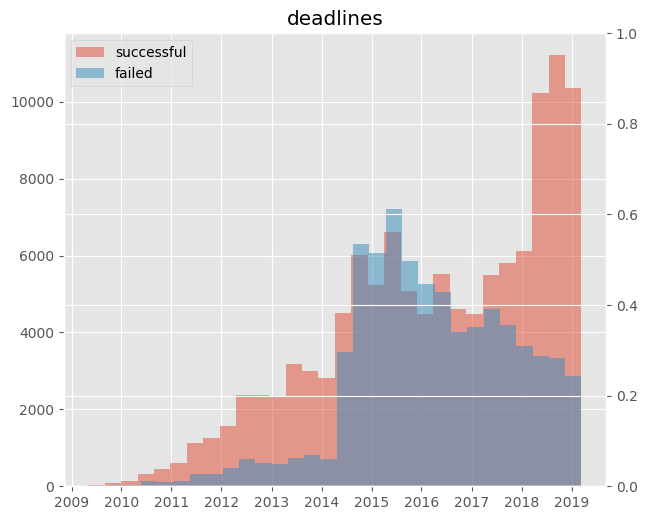

In [24]:
ig, ax1 = plt.subplots(figsize=(7, 6), dpi=100)
plt.hist(df_dates.loc[df_dates.state=='successful', 'deadline'], label='successful', alpha=0.5, bins=30)
plt.hist(df_dates.loc[df_dates.state=='failed', 'deadline'], label='failed', alpha=0.5, bins=30)
plt.title('deadlines')
plt.legend();
ax2 = ax1.twinx()

In [25]:
df['running_time'] = df['deadline'] - df['launched_at']
df['marketing_time'] = df['launched_at'] - df['created_at']

### FX

In [26]:
(df['fx_rate'] - df['static_usd_rate']).describe().round(4)
print(df.query('(fx_rate - static_usd_rate) > 0.05').shape[0])

3590


In [27]:
df['fx_dif'] = (df['fx_rate'] - df['static_usd_rate'])/df['static_usd_rate']

### Goal

In [28]:
misclassifications = df.query('goal < usd_pledged and state == "failed"').count() +\
df.query('goal > usd_pledged and state == "successful"').count()
print("Amount of misclassifications using usd_pledged: {}".format(misclassifications[0]))

misclassifications = df.query('goal < converted_pledged_amount and state == "failed"').count() +\
df.query('goal > converted_pledged_amount and state == "successful"').count()
print("Amount of misclassifications using converted_pledged_amount: {}".format(misclassifications[0]))

misclassifications = df.query('goal < pledged and state == "failed"').count() +\
df.query('goal > pledged and state == "successful"').count()
print("Amount of misclassifications using pledged: {}".format(misclassifications[0]))

Amount of misclassifications using usd_pledged: 7631
Amount of misclassifications using converted_pledged_amount: 7669
Amount of misclassifications using pledged: 4


When comparing the goal amount to the converted_pledged_amount, there are 7669 success misclassifications, however when comparing pledged and goal there are merely 4 misclassificaition. This indicates that the goal amount is given in the original currency and has not been converted to USD yet. 

In [29]:
df['usd_goal'] = df['goal'] * df['fx_rate']
misclassifications = df.query(
    'usd_goal < converted_pledged_amount and state == "failed" or \
usd_goal > converted_pledged_amount and state == "successful"').count()
print(
    "Amount of misclassifications using converted_pledged_amount & fx_rate*goal: {}"
    .format(misclassifications[0]))

df['usd_goal'] = df['goal'] * df['static_usd_rate']
misclassifications = df.query(
    'usd_goal < converted_pledged_amount and state == "failed" or \
usd_goal > converted_pledged_amount and state == "successful"').count()
print(
    "Amount of misclassifications using converted_pledged_amount & static_usd_rate*goal: {}"
    .format(misclassifications[0]))

df['usd_goal'] = df['goal'] * df['fx_rate']
misclassifications = df.query(
    'usd_goal < usd_pledged and state == "failed" or \
usd_goal > usd_pledged and state == "successful"').count()
print(
    "Amount of misclassifications using usd_pledged & fx_rate*goal: {}".format(
        misclassifications[0]))

df['usd_goal'] = df['goal'] * df['static_usd_rate']
misclassifications = df.query(
    'usd_goal < usd_pledged and state == "failed" or \
usd_goal > usd_pledged and state == "successful"').count()
print(
    "Amount of misclassifications using usd_pledged & static_usd_rate*goal: {}"
    .format(misclassifications[0]))

Amount of misclassifications using converted_pledged_amount & fx_rate*goal: 1361
Amount of misclassifications using converted_pledged_amount & static_usd_rate*goal: 2296
Amount of misclassifications using usd_pledged & fx_rate*goal: 1366
Amount of misclassifications using usd_pledged & static_usd_rate*goal: 153


In [30]:
df.drop(df.query('usd_goal < usd_pledged and state == "failed" or \
              usd_goal > usd_pledged and state == "successful"').index,
        inplace=True,)
df=df.reset_index(drop=True);

As there are only 153 misclassifications, when converting the the goal using the static usd rate and comparing it to the pledged usd it can be assumed that this is the best metric to use with regard to consistency. The 153 misclassifications are likely to be to do to faulty data and will therefore be removed from the dataset.

### ID

In [31]:
df.id.nunique()

168860

In [32]:
df.id.unique()[0]

928751314

### Location

In [33]:
df.location.unique()[0]

'{"id":2400549,"name":"Euless","slug":"euless-tx","short_name":"Euless, TX","displayable_name":"Euless, TX","localized_name":"Euless","country":"US","state":"TX","type":"Town","is_root":false,"urls":{"web":{"discover":"https://www.kickstarter.com/discover/places/euless-tx","location":"https://www.kickstarter.com/locations/euless-tx"},"api":{"nearby_projects":"https://api.kickstarter.com/v1/discover?signature=1552595201.21559901337a1cbb442882fc58ce69fbdd8eec26&woe_id=2400549"}}}'

In [34]:
#df['location_id'] = dict_extract(df.location, '"id":', ',')
#df['location_id'].nunique()

In [35]:
df['location_name'] = dict_extract(df.location, '"short_name":"', '",')
df['location_name'] = df['location_name'].str.split(", ",expand=True)[1]

In [36]:
print(df['location_name'].nunique())
print(df['location_name'].unique())

243
['TX' 'CA' 'Lithuania' 'MI' 'MD' 'CT' 'UT' 'UK' 'GA' 'IL' 'NY' 'CO'
 'France' 'AU' 'TN' 'PA' 'NZ' 'MA' 'MN' 'NE' 'Spain' 'NJ' 'NC' 'Italy'
 'FL' 'VA' 'SD' 'Norway' 'VT' 'ID' 'OR' 'AZ' 'Netherlands' 'NV' 'MT' 'ME'
 'LA' 'Canada' 'WA' 'IN' 'Singapore' 'KY' 'Argentina' None 'Mexico'
 'Sweden' 'India' 'Ireland' 'DC' 'Germany' 'Peru' 'SC' 'Chile' 'Indonesia'
 'Belgium' 'OH' 'AR' 'Japan' 'KS' 'HI' 'Hong Kong' 'DE' 'WI' 'AL' 'Kenya'
 'MO' 'South Korea' 'Iran' 'OK' 'RI' 'NH' 'Iceland' 'Israel' 'Puerto Rico'
 'Hungary' 'Bulgaria' 'Denmark' 'Switzerland' 'MS' 'Jamaica' 'China' 'AK'
 'Czech Republic' 'IA' 'Russia' 'Ecuador' 'Greece' 'NM' 'WV' 'Austria'
 'Suriname' 'Thailand' 'Poland' 'ND' 'Sierra Leone' 'Taiwan' 'Brazil'
 'Panama' 'Ghana' 'Uganda' 'WY' 'Guatemala' 'Slovenia' 'South Africa'
 'Egypt' 'Bangladesh' 'Liberia' 'Viet Nam' 'Morocco' 'Rwanda' 'Serbia'
 'Latvia' 'Slovakia' 'Congo' 'Ukraine' 'Belize' 'Costa Rica'
 'Svalbard and Jan Mayen' 'Nigeria' 'Portugal' "Cote d'Ivoire" 'Nepal'
 'S

In [37]:
df.drop('location', axis= 1, inplace=True)

In [38]:
print(df['country'].nunique())
print(sorted(df['country'].unique()))

22
['AT', 'AU', 'BE', 'CA', 'CH', 'DE', 'DK', 'ES', 'FR', 'GB', 'HK', 'IE', 'IT', 'JP', 'LU', 'MX', 'NL', 'NO', 'NZ', 'SE', 'SG', 'US']


### Name

In [39]:
df['name_length']=df['name'].str.len()

### Pledged Amount

In [40]:
(df['usd_pledged'] - df['static_usd_rate']* df['pledged']).describe().round()

count    192511.0
mean         -0.0
std           0.0
min          -0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
dtype: float64

In [41]:
(df['converted_pledged_amount'] - df['usd_pledged']).describe().round()

count    192511.0
mean        -11.0
std         666.0
min     -100666.0
25%           0.0
50%           0.0
75%           0.0
max       38056.0
dtype: float64

In [42]:
df.query('(converted_pledged_amount - usd_pledged)/usd_pledged > 0.05').shape[0]

756

As usd_pledged is the product of the rate and the original pledged amount, the later two can be removed as features. By definition, the converted_pledged_amount and usd_pledged are assumed to be identical and smaller differences can be attributed to different conversions.

In [43]:
df['pledged_per_backer']=df['usd_pledged']/df['backers_count']
df['pledged_per_backer'].describe()
df[['state','pledged_per_backer']].groupby(['state']).describe().round(2)

pledged_per_backer                                             \
                        count   mean     std   min    25%    50%     75%   
state                                                                      
failed                60187.0  57.89  145.88  0.46  10.40  29.99   61.78   
successful           117315.0  92.41  136.20  1.00  38.79  61.71  102.27   

                     
                max  
state                
failed      10000.0  
successful  10000.0

### Payout

In [44]:
df['payout'] = np.where(df['usd_pledged'] >= df['usd_goal'], df['usd_pledged'],0)

### Photo

In [45]:
df.photo[0]

'{"key":"assets/017/766/989/dd9f18c773a8546d996293a20e2c422b_original.jpg","full":"https://ksr-ugc.imgix.net/assets/017/766/989/dd9f18c773a8546d996293a20e2c422b_original.jpg?ixlib=rb-1.1.0&crop=faces&w=560&h=315&fit=crop&v=1502053663&auto=format&frame=1&q=92&s=90bdce91db36494610fd98402dfe9712","ed":"https://ksr-ugc.imgix.net/assets/017/766/989/dd9f18c773a8546d996293a20e2c422b_original.jpg?ixlib=rb-1.1.0&crop=faces&w=352&h=198&fit=crop&v=1502053663&auto=format&frame=1&q=92&s=3484e37f5556e7089af3873bbb852acc","med":"https://ksr-ugc.imgix.net/assets/017/766/989/dd9f18c773a8546d996293a20e2c422b_original.jpg?ixlib=rb-1.1.0&crop=faces&w=272&h=153&fit=crop&v=1502053663&auto=format&frame=1&q=92&s=b4e6fc952f50f318de29780405e6c570","little":"https://ksr-ugc.imgix.net/assets/017/766/989/dd9f18c773a8546d996293a20e2c422b_original.jpg?ixlib=rb-1.1.0&crop=faces&w=208&h=117&fit=crop&v=1502053663&auto=format&frame=1&q=92&s=3bc1f2c21cba6e531e9de54219841e5a","small":"https://ksr-ugc.imgix.net/assets/017/

In [46]:
df.drop('photo', axis=1, inplace=True)

### Profile

In [47]:
df.profile[0]

'{"id":3094785,"project_id":3094785,"state":"active","state_changed_at":1505402530,"name":"The Ofrenda Oracle Deck","blurb":"A colorful Dia de los Muertos themed oracle deck & guidebook for all you tarot lovers, from mixed media artist Lisa Vollrath.","background_color":"","text_color":"000000","link_background_color":"fd7a00","link_text_color":"fdfcfc","link_text":"Purchase a Deck","link_url":"http://www.makeplayingcards.com/sell/lisavollrath","show_feature_image":false,"background_image_opacity":0.8,"should_show_feature_image_section":true,"feature_image_attributes":{"image_urls":{"default":"https://ksr-ugc.imgix.net/assets/017/766/989/dd9f18c773a8546d996293a20e2c422b_original.jpg?ixlib=rb-1.1.0&crop=faces&w=1552&h=873&fit=crop&v=1502053663&auto=format&frame=1&q=92&s=303e28e5899b51063369a2c0370872c6","baseball_card":"https://ksr-ugc.imgix.net/assets/017/766/989/dd9f18c773a8546d996293a20e2c422b_original.jpg?ixlib=rb-1.1.0&crop=faces&w=560&h=315&fit=crop&v=1502053663&auto=format&frame=

In [48]:
df['profile_id'] = dict_extract(df.profile, '"id":', ',"')
df['profile_id'] = df['profile_id'].astype('int')
df['profile_id'].nunique()
df.drop('profile', axis=1, inplace=True)

The profile_id and id are different variables however they seem both to identify the individual projects.

### Starrable & Communication

In [49]:
df.query('is_starrable == True or disable_communication == True').count()[0]
df.drop(['is_starrable', 'disable_communication'], axis=1, inplace=True)

Is_starrable and disable_communication are variables, that cannot be True for projects with state failed or successful. Thus, they cannot be used as features. 

### URLs

In [50]:
df.urls[0]

'{"web":{"project":"https://www.kickstarter.com/projects/lisavollrath/the-ofrenda-oracle-deck?ref=discovery_category_newest","rewards":"https://www.kickstarter.com/projects/lisavollrath/the-ofrenda-oracle-deck/rewards"}}'

In [51]:
df.drop('urls', axis=1, inplace=True)

## Label and Features

In [52]:
df = df.reindex(sorted(df.columns), axis=1)
df.columns

Index(['backers_count', 'blurb', 'blurb_length', 'category',
       'converted_pledged_amount', 'country', 'created_at', 'creator_id',
       'currency', 'currency_symbol', 'currency_trailing_code',
       'current_currency', 'deadline', 'fx_dif', 'fx_rate', 'goal', 'id',
       'launched_at', 'location_name', 'marketing_time', 'name', 'name_length',
       'payout', 'pledged', 'pledged_per_backer', 'profile_id', 'running_time',
       'slug', 'source_url', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'state_dum', 'static_usd_rate', 'usd_goal',
       'usd_pledged', 'usd_type'],
      dtype='object')

### Data leakage mitigation

In [53]:
leakage = ['backers_count',
           'converted_pledged_amount',
           'payout',
           'pledged',
           'pledged_per_backer',
           'spotlight',
           'state',
           'state_dum',
           'usd_pledged']

### Features

In [102]:
# Feature selection

features = ['blurb_length',            
            'category',
            'country',
            'currency',
            'fx_dif',
            'marketing_time',
            'name_length',
            'running_time',
            'usd_goal',
            'staff_pick',
           ]

#useless = ['location_name', 'name', 'slug', 'source_url', 'blurb']

#features = list(set(df)-set(leakage)-set(useless))
features


['blurb_length',
 'category',
 'country',
 'currency',
 'fx_dif',
 'marketing_time',
 'name_length',
 'running_time',
 'usd_goal',
 'staff_pick']

In [55]:
removed_features = list(set(df)-set(features))
removed_features

['usd_pledged',
 'name',
 'backers_count',
 'id',
 'deadline',
 'pledged',
 'payout',
 'converted_pledged_amount',
 'pledged_per_backer',
 'currency_symbol',
 'blurb',
 'state_dum',
 'goal',
 'launched_at',
 'source_url',
 'profile_id',
 'created_at',
 'slug',
 'usd_type',
 'location_name',
 'fx_rate',
 'currency_trailing_code',
 'state',
 'creator_id',
 'spotlight',
 'static_usd_rate',
 'current_currency',
 'state_changed_at']

### Assigning Label and Features

In [56]:
X = df[features]
y = df['state_dum']
print(X.shape)
print(y.shape)

(192511, 10)
(192511,)


In [57]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192511 entries, 0 to 192510
Data columns (total 10 columns):
blurb_length      192509 non-null float64
category          192511 non-null object
country           192511 non-null object
currency          192511 non-null object
fx_dif            192511 non-null float64
marketing_time    192511 non-null int64
name_length       192511 non-null int64
running_time      192511 non-null int64
usd_goal          192511 non-null float64
staff_pick        192511 non-null bool
dtypes: bool(1), float64(3), int64(3), object(3)
memory usage: 13.4+ MB


### Categorical Features

In [58]:
bool_features = list(X.columns[X.dtypes==bool])
cat_features = list(X.columns[X.dtypes==object])+ bool_features
cat_features

['category', 'country', 'currency', 'staff_pick']

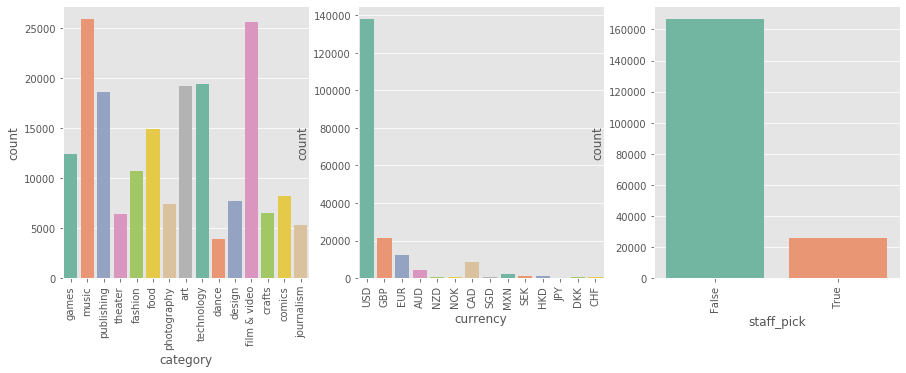

In [108]:
cat_plots = [x for x in df[cat_features] if df[x].nunique()<20]             
fig, ax = plt.subplots(len(cat_plots)//3+len(cat_plots)%3, 3, figsize=(15, 5))
for variable, subplot in zip(cat_plots, ax.flatten()):
    sns.countplot(df[variable], ax=subplot, palette="Set2")
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

### Numerical Features

In [60]:
num_features = list(X.columns[X.dtypes!=object])
num_features

['blurb_length',
 'fx_dif',
 'marketing_time',
 'name_length',
 'running_time',
 'usd_goal',
 'staff_pick']

/Users/vivika/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/vivika/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/generic.py:7172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  result[mask] = np.nan
/Users/vivika/opt/anaconda3/envs/nf/lib/python3.6/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/vivika/opt/anaconda3/envs/nf/lib/python3.6/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


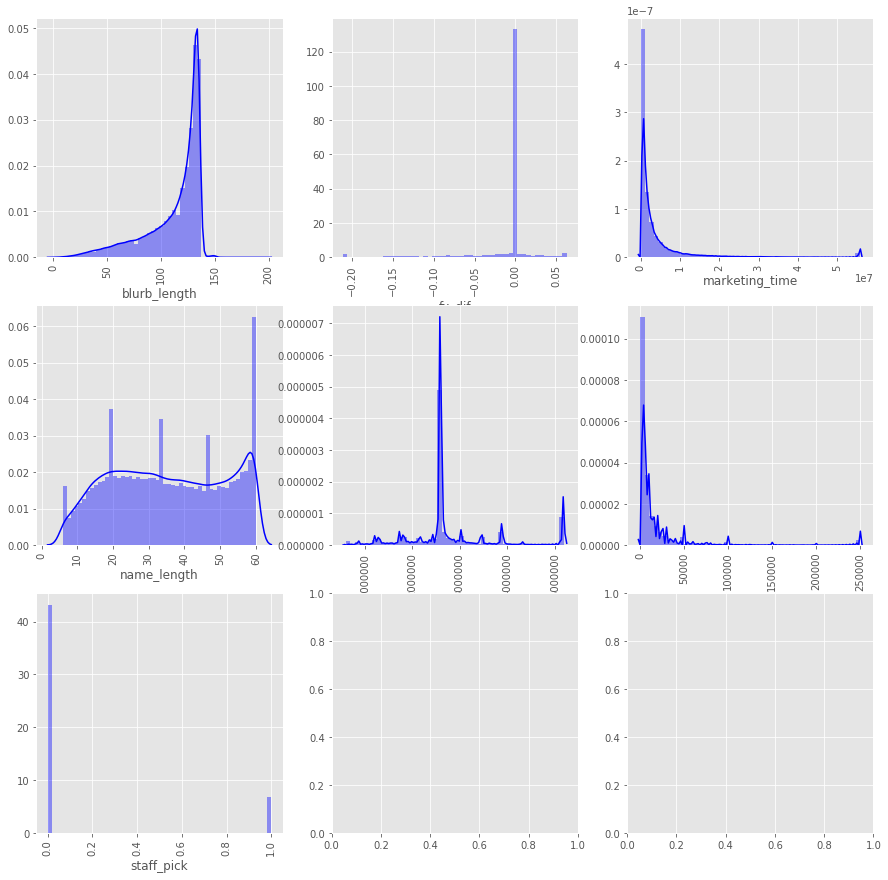

In [107]:
fig, ax = plt.subplots(len(num_features)//3+len(num_features)%3, 3, figsize=(15, 15))
for variable, subplot in zip(num_features, ax.flatten()):
    lb = np.percentile(df[variable], 1)
    ub = np.percentile(df[variable], 99)
    sns.distplot(df[variable].clip(lb,ub), ax=subplot, color='b')
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

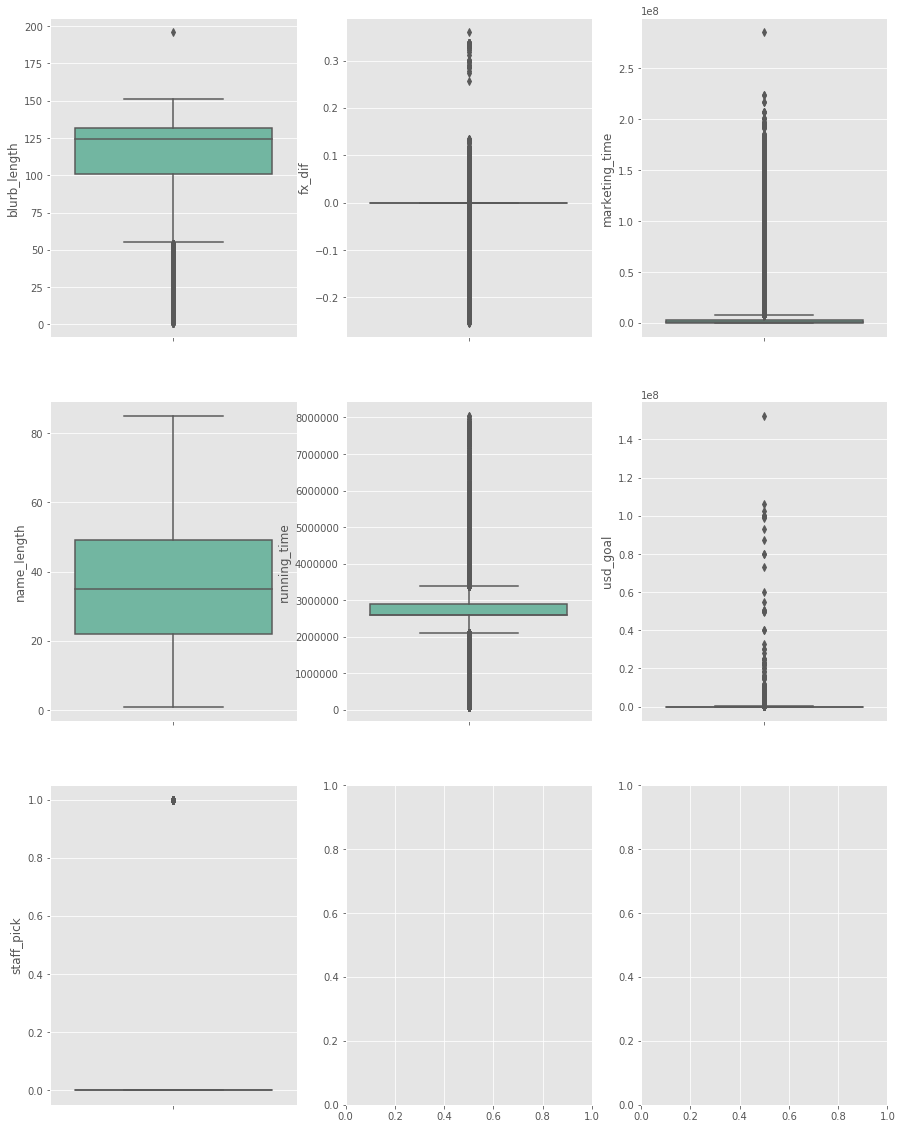

In [62]:
fig, ax = plt.subplots(len(num_features)//3+len(num_features)%3, 3, figsize=(15, 20))
for variable, subplot in zip(num_features, ax.flatten()):
    sns.boxplot(y=df[variable], ax=subplot, palette="Set2")

### Correlations

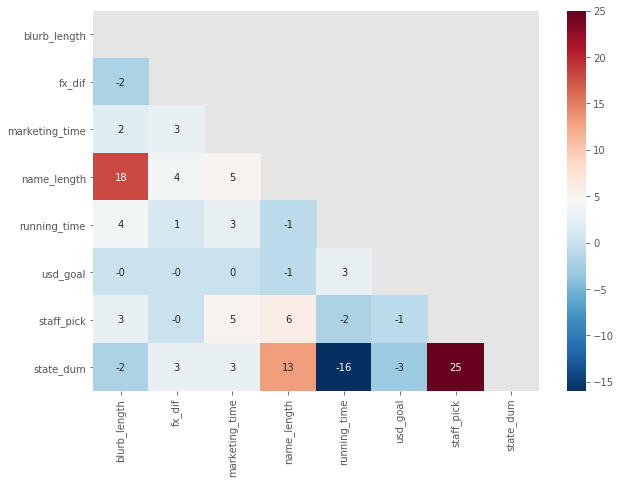

In [109]:
mask = np.triu(X[num_features].join(y).corr())
plt.figure(figsize = (10,7))
ax = sns.heatmap(round(X[num_features].join(y).corr()*100)
                 ,annot=True
                 ,mask=mask
                 ,cmap='RdBu_r')

## Model

### Preprocessing

In [64]:
# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

In [65]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (154008, 10)
X_test shape: (38503, 10)
y_train shape: (154008,)
y_test shape: (38503,)


In [66]:
X_train.nunique()

blurb_length         151
category              15
country               22
currency              14
fx_dif             15098
marketing_time    133132
name_length           85
running_time       39754
usd_goal           38902
staff_pick             2
dtype: int64

In [67]:
y_train.nunique()

2

In [68]:
# Pipeline for numerical features
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [69]:
# Complete pipeline
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

### Pipline

In [70]:
models={'logreg': LogisticRegression(max_iter=1000, random_state=RSEED,n_jobs=-1),
        'tree': DecisionTreeClassifier(criterion = "gini", max_depth=3,random_state=RSEED),
        'forest': RandomForestClassifier(random_state=RSEED, max_features='sqrt', n_jobs=-1),
        'XGB' : XGBClassifier(random_state=RSEED,  n_jobs=-1),
        'AdaBoost' : AdaBoostClassifier(random_state=RSEED)}


### Predictive Modelling

In [96]:
stop run all through invalid syntax

SyntaxError: invalid syntax (<ipython-input-96-5b58cfb9f583>, line 1)

In [71]:
results = pd.DataFrame(columns=['Model','Accuracy','Recall','Precision'])
i=0

for m in models.items():
    # Building a full pipeline with our preprocessor and a Classifier
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        (m[0], m[1])
    ])

    # Making predictions on the training set using cross validation as well as calculating the probabilities 
    y_train_predicted = cross_val_predict(pipe, X_train, y_train.values.ravel(), cv=5, verbose=5)

    # Calculating the accuracy for the LogisticRegression Classifier
    temp = pd.DataFrame({
        'Model': m[0],
        'Accuracy': accuracy_score(y_train, y_train_predicted),
        'Recall' : recall_score(y_train, y_train_predicted),
        'Precision': precision_score(y_train, y_train_predicted)
    }, index=[i])
    i+=1

    results = pd.concat([results, temp])
    print('Cross validation scores:')
    print('-------------------------')
    print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
    print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted)))
    print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Cross validation scores:
-------------------------
Accuracy: 0.72
Recall: 0.86
Precision: 0.73


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Cross validation scores:
-------------------------
Accuracy: 0.68
Recall: 0.85
Precision: 0.69


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Cross validation scores:
-------------------------
Accuracy: 0.77
Recall: 0.87
Precision: 0.78


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Cross validation scores:
-------------------------
Accuracy: 0.75
Recall: 0.88
Precision: 0.75


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   21.4s remaining:    0.0s


Cross validation scores:
-------------------------
Accuracy: 0.75
Recall: 0.85
Precision: 0.76


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.7s finished


In [72]:
results.round(2)

,Model,Accuracy,Recall,Precision
0,logreg,0.72,0.86,0.73
1,tree,0.68,0.85,0.69
2,forest,0.77,0.87,0.78
3,XGB,0.75,0.88,0.75
4,AdaBoost,0.75,0.85,0.76


### Optimizing AdaBoost (Recall) via Grid Search

In [73]:
ADA_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('AdaBoost', AdaBoostClassifier(random_state=RSEED))
    ])
ADA_param_grid = {
    'AdaBoost__n_estimators':[50, 100, 150, 200, 250, 300],                
    'AdaBoost__learning_rate':[0.1, 0.5, 1.]}  


In [74]:
ADA_grid = GridSearchCV(ADA_pipe, param_grid=ADA_param_grid, cv=5, scoring='recall', 
                           verbose=5, n_jobs=-1)
ADA_grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 11.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer_num',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                

In [75]:
# Show best parameters
print('Best score:\n{:.2f}'.format(ADA_grid.best_score_))
print("Best parameters:\n{}".format(ADA_grid.best_params_))


Best score:
0.93
Best parameters:
{'AdaBoost__learning_rate': 0.1, 'AdaBoost__n_estimators': 50}


In [76]:
# Save best model as best_model
ADA_best_model = ADA_grid.best_estimator_['AdaBoost']

In [77]:
preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)
y_train_predicted = ADA_best_model.predict(X_train_preprocessed)
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted)))

Accuracy: 0.72
Recall: 0.93
Precision: 0.70


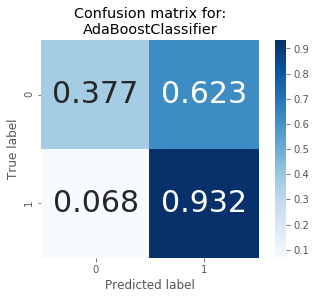

In [78]:
cm = confusion_matrix(y_train, ADA_best_model.predict(X_train_preprocessed))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
# normalize the data
# view with a heatmap
plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30},
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(ADA_best_model.__class__.__name__));

### Optimizing Random Forest (Accuracy) via Grid Search 

In [79]:
forest_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('forest', RandomForestClassifier(random_state=RSEED, n_jobs=-1))
    ])
forest_param_grid = {
    'forest__min_samples_split': [3, 5, 10],
    'forest__n_estimators' : [100, 300, 500],
    'forest__max_depth': [1, 3, 5, 10],
    'forest__max_features': [3, 5, 7, 10, 20, 30]}

In [80]:
forest_grid = GridSearchCV(forest_pipe, param_grid=forest_param_grid, cv=3, scoring='accuracy', 
                           verbose=10, n_jobs=-1)
forest_grid.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  7

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer_num',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                

In [81]:
# Show best parameters
print('Best score:\n{:.2f}'.format(forest_grid.best_score_))
print("Best parameters:\n{}".format(forest_grid.best_params_))

Best score:
0.75
Best parameters:
{'forest__max_depth': 10, 'forest__max_features': 20, 'forest__min_samples_split': 3, 'forest__n_estimators': 500}


In [82]:
# Save best model as best_model
forest_best_model = forest_grid.best_estimator_['forest']

preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)

y_train_predicted_forest = forest_best_model.predict(X_train_preprocessed)
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_forest)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted_forest)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted_forest)))

Accuracy: 0.75
Recall: 0.89
Precision: 0.75


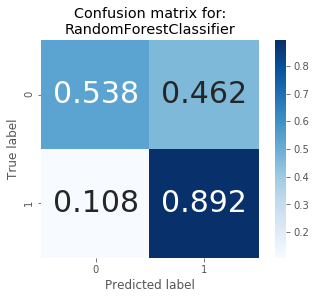

In [83]:
cm = confusion_matrix(y_train, forest_best_model.predict(X_train_preprocessed))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
# normalize the data
# view with a heatmap
plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30},
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(forest_best_model.__class__.__name__));

### Final evaluation

#### AdaBoost

In [84]:
# Preparing the test set 
preprocessor.fit(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [85]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_test_predicted = ADA_best_model.predict(X_test_preprocessed)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted)))

Accuracy: 0.71
Recall: 0.93
Precision: 0.70


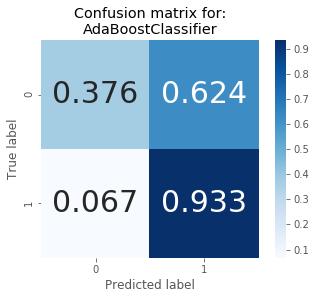

In [86]:
cm = confusion_matrix(y_test, ADA_best_model.predict(X_test_preprocessed))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
# normalize the data
# view with a heatmap
plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30},
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(ADA_best_model.__class__.__name__));

#### Random Forest

In [89]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
forest_y_test_predicted = forest_best_model.predict(X_test_preprocessed)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, forest_y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, forest_y_test_predicted)))
print("Precision: {:.2f}".format(precision_score(y_test, forest_y_test_predicted)))

Accuracy: 0.75
Recall: 0.89
Precision: 0.75


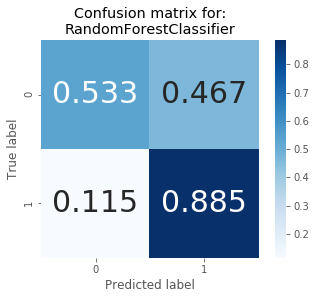

In [90]:
cm = confusion_matrix(y_test, forest_best_model.predict(X_test_preprocessed))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
# normalize the data
# view with a heatmap
plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30},
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(forest_best_model.__class__.__name__));

### Test Live Data

In [103]:
live = data.query('state == "live"').copy()
#live = live.reset_index(drop=True)

live['blurb_length']=live['blurb'].str.len()

live_cat = pd.DataFrame.from_dict([json.loads(x) for x in live.category])
live_cat['urls_web'] = pd.DataFrame.from_dict([x for x in live_cat.urls])
live_cat['urls_web_discover'] = pd.DataFrame.from_dict([x for x in live_cat.urls_web])
live['category'] = live_cat.slug.str.split("/",expand=True,)

live['fx_dif'] = (live['fx_rate'] - live['static_usd_rate'])/live['static_usd_rate']

live['running_time'] = live['deadline'] - live['launched_at']
live['marketing_time'] = live['launched_at'] - live['created_at']

live['name_length']=live['name'].str.len()

live['usd_goal'] = live['goal'] * live['static_usd_rate']

In [104]:
X_live = live[features]

preprocessor.fit(X_train)
X_live_preprocessed = preprocessor.transform(X_live)
y_live_predicted = forest_best_model.predict(X_live_preprocessed)

live['prediction'] = y_live_predicted

present = features+['prediction']

live[present].head().round(2)

,blurb_length,category,country,currency,fx_dif,marketing_time,name_length,running_time,usd_goal,staff_pick,prediction
0,13,fashion,US,USD,0.00,6764170,24,4316400,28000.00,False,0
12,130,technology,US,USD,0.00,916312,16,4314846,10000.00,False,0
27,131,art,GB,GBP,0.33,553003,20,2592000,26319.91,False,0
59,112,design,US,USD,0.00,1054175,38,2592000,15000.00,False,1
72,50,film & video,US,USD,0.00,1621665,32,2588400,1000.00,False,1
93,123,fashion,US,USD,0.34,59242742,39,5180400,40000.00,False,0
96,16,fashion,US,USD,0.00,585003,36,2631598,350.00,False,1
104,74,music,FR,EUR,-0.01,762728,49,3884400,18502.37,False,1
110,90,music,US,USD,0.00,6831026,19,3268182,1300.00,False,1
115,128,art,GB,GBP,0.01,1722334,29,2415600,1935.01,False,1


In [106]:
live.query('prediction == 1')['usd_goal'].sum().round()

35233796.0